# Seq2seq
* Sequence to Sequence : 한 문장(시퀀스)을 다른 문장(시퀀스)으로 변환하는 모델입니다. 
* 고정된 길이의 sequence를 입력받아, 알맞은 길이의 sequence를 출력해 줍니다. 
* ex) "I am a student" -> [Seq2Seq model] -> "je suis étudiant" 

## Seq2seq 모델 구조 
* LSTM(또는 GRU) 기반 **encoder part**와 **decoder part**로 구성되어 있습니다. 
* Encoder : 입력 sequence의 상태 추출합니다. 
* Decoder : encoder에서 생성된 상태를 초기값으로 이용하여 순차적으로 sequence를 생성합니다. 

![img](https://user-images.githubusercontent.com/43749571/97678810-c3c9b880-1ad7-11eb-8d90-35580eca18c2.png)

1. **Encoder**는 'I am a student'라는 입력 문장을 받아 Context 벡터를 만듭니다.
2. **Context 벡터**는 'I am a student'에 대한 정보를 압축하고 있는 벡터입니다. 
3. Context 벡터는 다시 **Decoder**로 전달되며 Decoder는 이를 활용하여 최종적으로 'je suis étudiant'라는 불어 문장을 생성합니다.


## Training Phase 

<img width="661" alt="스크린샷 2020-10-29 오후 8 19 24" src="https://user-images.githubusercontent.com/43749571/97678854-d217d480-1ad7-11eb-9821-7256b39e05ce.png">

* 입력 문장을 단어 단위로 Tokenize 한 후, 순차적으로 LSTM(또는 GRU)에 입력받습니다. 
    - ex) 'I', 'like', 'an', 'apple', '.' 
* sequence의 마지막 단에서 상태를 추출합니다. 
    - $h_{final}$, $c_{final}$ 상태 벡터 

.


* **EOS** : 입력 sequence의 종료를 나타냅니다. (End Of Sequence) 
* Seq2seq에서는 EOS가 상당히 중요한데,
    - EOS를 이용해 sequence의 종료 시점을 알 수 있고, 
    - LSTM(또는 GRU) 특성 중 같은 가중치를 사용한다는 점에서 무한히 확장 가능하기 때문입니다. 


.

* 추가적으로, Seq2seq 구조에서 성능을 높이기 위해 입력 데이터를 반전(reverse) 시키는 방법이 있습니다.
* ex) I like an apple -> ellpa na ekil I 
* Gradient의 전파가 원활해지기 때문에 학습이 빨라지고 정확도가 개선된다고 합니다.  

<img width="661" alt="스크린샷 2020-10-29 오후 8 29 32" src="https://user-images.githubusercontent.com/43749571/97678893-e0fe8700-1ad7-11eb-883f-b5bc01dd65a5.png">

* 첫 LSTM에서 EOS를 입력으로 받습니다. 
* 두번째 LSTM에서는 첫번째 값을 입력으로 받습니다. 
* EOS에 도달할 때 까지 이와 같은 과정을 순차적으로 진행합니다. 



* Decoder 단계에서는 **Teacher Forcing** 방식으로 Training을 진행합니다. 

### Teacher Forcing 

![image2](https://user-images.githubusercontent.com/43749571/97678957-f673b100-1ad7-11eb-99eb-79749b4d3315.png)

* target word(Ground Truth)를 디코더의 다음 입력으로 넣어주는 기법입니다. 
* 즉, **(n-1) 스텝의 실제값**을 n 스텝의 입력값으로 이용합니다. 


. 


* 보통의 RNN/LSTM 등의 구조에서는 (n-1) 예측값을 n번째의 input으로 넣어주게 됩니다. 
* 하지만 위의 경우 잘못된 예측이 선행되면 계속적으로 잘못된 예측이 이루어지게 됩니다. 
* 또한 이러한 단점은 학습 초기에 학습 속도 저하의 요인이 됩니다. 
* 따라서 정확한 데이터로 훈련하기 위해, 예측값을 다음 스텝으로 넘기지 않고 **실제값을 매번 입력값으로 사용하는 방법**을 사용합니다. 

## Inference Phase 

<img width="884" alt="스크린샷 2020-10-29 오후 9 25 15" src="https://user-images.githubusercontent.com/43749571/97679011-0c817180-1ad8-11eb-9d66-eefe19689bd3.png">

* Training Phase에서는 Label을 알고 있기 때문에 입력에 참값을 넣어 Teacher Forcing 방식으로 학습합니다. 
* 반면 Inference Phase에서는 참값을 알 수 없기 때문에, **직전의 출력값과 상태 벡터**를 다음 LSTM의 입력 및 초기 상태로 이용하여 순차적으로 출력값을 얻습니다. 

# Code 
* https://towardsdatascience.com/natural-language-understanding-with-sequence-to-sequence-models-e87d41ad258b
* [ATIS dataset](https://catalog.ldc.upenn.edu/docs/LDC93S4B/corpus.html)을 이용하여 **Slot Filling** 진행하기 

In [1]:
cd /content/drive/My Drive/Stat/2020-2-NLP/4-Seq2Seq

/content/drive/My Drive/Stat/2020-2-NLP/4-Seq2Seq


In [2]:
import tensorflow as tf
tf.__version__ 

'2.3.0'

In [3]:
import pandas as pd 
import numpy as np 

import os
import pickle

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

## Slot Filling 
* NLU (Natural Language Understanding)
* 사용자의 발화로부터 대화의 도메인(domain), 의도(intent), 의미적 슬롯(semantic slot)을 분류합니다. 
* 슬롯을 채움으로써 자연어를 이해하는 작업을 수행할 수 있습니다. 
* ex) "일요일에 서울에서 부산으로 가는 기차표 예약해줘"
    - domain : 기차 
    - intent : 표 예약 
    - semantic_slot : 일요일=날짜, 서울=출발지, 부산=목적지

## Data Load 

<img width="661" alt="스크린샷 2020-10-30 오후 2 39 40" src="https://user-images.githubusercontent.com/43749571/97679053-1dca7e00-1ad8-11eb-9bee-f804e3fbdf5a.png">

- Query text : 문장(질문)을 tokenize하여 corpus 단위로 나눈 것 
- Query vector : Query text에 고유값을 부여해 준 것 ($\simeq$ one-hot encoding) 
- Intent label : 문장(질문)의 의도   
- Slot text : 각 corpus에서 분류한 semantic slot 
- Slot vector : Slot text에 고유값을 부여해 준 것 ($\simeq$ one-hot encoding)
    

In [4]:
def load_ds(fname='atis.train.pkl', verbose=True):
    with open(fname, 'rb') as stream:
        ds, dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts

In [5]:
# convert pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:  # seq2seq 모델 적용을 위해, start token과 end token 설정 
        i2s[178] = 'BOS'     # 문장 시작에 BOS 
        i2s[179] = 'EOS'     # 문장 끝에 EOS 
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)

    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []

        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])

        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179

        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])

        if i in to_show and verbose:
            print('Query text:', q)
            print('Query vector: ', query[i])
            print('Intent label: ', i2in[intent[i][0]])
            print('Slot text: ', slot)
            print('Slot vector: ', slot_vector)
            print('*'*74)

    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

In [6]:
# load ATIS training dataset  
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

Done  loading:  atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what kinds of planes are used by american airlines EOS
Query vector:  [178 916 515 646 686 228 892 277 212 200 179]
Intent label:  aircraft
Slot text:  O O O O O O O O B-airline_name I-airline_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 2, 83, 128]
**************************************************************************
Query text: BOS what is the distance from los angeles international airport to los angeles EOS
Query vector:  [178 916 498 827 373 444 563 216 496 203 851 563 216 179]
Intent label:  distance
Slot text:  O O O O O O B-fromloc.airport_name I-fromloc.airport_name I-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name I-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 47, 109, 109, 109, 128, 78, 125, 128]
**************************************************************************
Query text: BOS what does

In [7]:
# load ATIS test dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS which flights leave chicago on april twelfth and arrive in indianapolis in the morning EOS
Query vector:  [178 920 429 537 297 654 227 878 215 236 482 489 482 827 606 179]
Intent label:  flight
Slot text:  O O O O B-fromloc.city_name O B-depart_date.month_name B-depart_date.day_number O O O B-toloc.city_name O O B-arrive_time.period_of_day O
Slot vector:  [128, 128, 128, 128, 48, 128, 28, 27, 128, 128, 128, 78, 128, 128, 12, 128]
**************************************************************************
Query text: BOS what is the ground transportation between the charlotte airport charlotte airport and downtown charlotte EOS
Query vector:  [178 916 498 827 457 866 259 827 294 203 294 203 215 380 294 179]
Intent label:  ground_service
Slot text:  O O O O O O O O B-airport_name I-airport_name B-city_name I-city_name O O B-city_name O
Slot vector:  [128, 128, 128,

In [8]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

# 각 intent에 해당하는 query와 이에 대한 slot filling의 예시 
df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
    df_small.loc[j] = df[df.intent==i].iloc[0]
    j = j+1
    
df_small

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


In [9]:
# slot category 
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
    df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


## Model 

<img width="661" alt="스크린샷 2020-10-30 오후 3 10 26" src="https://user-images.githubusercontent.com/43749571/97679164-43578780-1ad8-11eb-9c7e-a6798eaba7bf.png">

In [10]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [11]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### Training Phase 

In [12]:
# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.

def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input, max_len)
    len_target = max(len_target, max_len)
    

    # Padding the input and output tensor to the maximum length
    # data를 최대 길이로 일정하게 맞춰주는 역할을 한다 (padding)

    # padding="post" : 각 sequence의 뒤쪽으로 패딩한다 (default = 0)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                               maxlen=len_input,
                                                               padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                 maxlen=len_target, 
                                                                 padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 

In [13]:
# train data 
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)

In [14]:
# test data 
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)

In [15]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

In [20]:
BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024


# Encoder layers 
encoder_inputs = Input(shape=(len_input_train,))  # 4978 
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)
encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]


# Decoder layers
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model.
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))



# Training the Models 

# Note that this model has three inputs:
#  encoder_inputs = [batch,encoded_words] from input (query)
#  decoder_inputs = [batch,encoded_words] from output (slots). This is the "teacher tensor".
#  decoder_out = [batch,encoded_words] from output (slots). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out)

# Use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
model.compile(optimizer=tf.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

In [21]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 256)      241408      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    33024       input_4[0][0]                    
_______________________________________________________________________________________

In [43]:
# 교차검증을 위해, train/validation set으로 나누기 
from sklearn.model_selection import train_test_split

In [44]:
# input data 
input_train, input_val, target_train, target_val = train_test_split(input_data_train, target_data_train, test_size=0.3, random_state=77)
print(input_train.shape, input_val.shape, target_train.shape, target_val.shape)

(3484, 48) (1494, 48) (3484, 48, 1) (1494, 48, 1)


In [45]:
# teacher data 
teacher_train, teacher_val, target_train, target_val = train_test_split(teacher_data_train, target_data_train, test_size=0.3, random_state=77)
print(teacher_train.shape, teacher_val.shape, target_train.shape, target_val.shape)

(3484, 48) (1494, 48) (3484, 48, 1) (1494, 48, 1)


In [46]:
epochs = 30 

history = model.fit([input_train, teacher_train], target_train,
                    batch_size=BATCH_SIZE, epochs=epochs,
                    validation_data=([input_val, teacher_val], target_val), verbose=1)

Epoch 1/30
55/55 [==============================] - 13s 228ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.9250
Epoch 2/30
55/55 [==============================] - 4s 68ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9401 - val_loss: 0.1961 - val_sparse_categorical_accuracy: 0.9472
Epoch 3/30
55/55 [==============================] - 4s 68ms/step - loss: 0.1951 - sparse_categorical_accuracy: 0.9489 - val_loss: 0.1802 - val_sparse_categorical_accuracy: 0.9537
Epoch 4/30
55/55 [==============================] - 4s 69ms/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1669 - val_sparse_categorical_accuracy: 0.9577
Epoch 5/30
55/55 [==============================] - 4s 69ms/step - loss: 0.1688 - sparse_categorical_accuracy: 0.9549 - val_loss: 0.1584 - val_sparse_categorical_accuracy: 0.9590
Epoch 6/30
55/55 [==============================] - 4s 68ms/step - loss: 0.1593 - sparse_categorical_ac

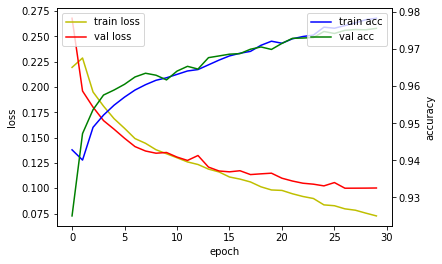

In [47]:
# model 학습 결과 시각화 
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()


# train / val loss 
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# train / val accuracy 
acc_ax.plot(history.history['sparse_categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_sparse_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [48]:
print("test loss, test acc:", model.evaluate([input_data_test, teacher_data_test], target_data_test))

28/28 [==============================] - 0s 14ms/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9728
test loss, test acc: [0.12251166254281998, 0.9727743268013]


### Inference Phase 

In [49]:
# 1. Encoder Model 
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])


# 2. Decoder Model 
# inference phase decoder를 위해, 새로운 tensor set을 생성합니다. 
# (teaching force 방식이 아닌, 직전 값을 Input으로 받는 Decoder)
# training phase에서 사용한 weight, bias를 사용할 수도 있습니다. 

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")

# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")

decoder_res, decoder_h, decoder_c = decoder_lstm(
                                                decoder_emb(inf_decoder_inputs), 
                                                initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))

inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [50]:
# 새로운 query 문장이 들어오면, 전처리를 수행해 줍니다. 

def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w



# Converts the given query (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (query)
# or target (slot)
# Output is 1-D: [timesteps/words]

def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec



# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a predicted slot string.

def predict_slots(input_query, infenc_model, infmodel, 
                  len_input=len_input_train, 
                  t2i=t2i_train, s2i=s2i_train, i2s=i2s_train,
                  len_target=len_target_train,
                  attention=False):
    sent_len = len(input_query.split())
    sv = query_to_vector(input_query, len_input, t2i)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = s2i["O"]
    stop_vec = s2i["O"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "EOS".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "BOS"
    output_query = ""
    # Start doing the feeding. Terminate when the model predicts an "EOS" or we reach the end
    # of the max target slot length.
    while cur_word != "EOS" and i < (len_target-1) and i < sent_len+1: # current word 가 EOS토큰을 만날 때 까지, 혹은 마지막까지 
        i += 1
        if cur_word != "BOS":
            output_query = output_query + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in) # predict!!! 
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().

        # predict 한 결과값에, 가장 큰 값을 가지고있는 인덱스를 넣어줍니다. 
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = i2s[np.argmax(nvec[0,0])]
    return output_query

In [51]:
# Slot Filling 이 잘 된 것을 확인할 수 있습니다. 
input_query = "what is the cheapest flight from boston to san francisco"
print(predict_slots(input_query, encoder_model, inf_model)) 

 O O O B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name


### 참고논문 
* Sequence to sequence learning with neural networks 
* Learning Phrase Representations using RNN Encoder–Decoder
* Attention-Based Recurrent Neural Network Models for Joint Intent Detection
and Slot Filling
for Statistical Machine Translation
* 자연어 이해를 위한 적대 학습 방법 

### 참고자료 
* https://bkshin.tistory.com/entry/NLP-13-%EC%8B%9C%ED%80%80%EC%8A%A4%ED%88%AC%EC%8B%9C%ED%80%80%EC%8A%A4seq2seq
* https://yjjo.tistory.com/35 
* https://blog.naver.com/PostView.nhn?blogId=sooftware&logNo=221790750668&categoryNo=0&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView
